# ST449 - Artificial Intelligence and Deep Learning

# Assignment 1 - Lent Term 2020-2021

---

## Instructions:

**Deadline**: February 26th, 2021, 7pm London time.


## P1. MNIST classification using multi-class logistic regression 

Consider a L2-regularized multi-class logistic regression model using the MNIST dataset. 

The model is given by
$\hat{y}=\sigma(W^TX+\mathbf{b})$, where $\sigma(\cdot)$ is 
the softmax function 
$$\sigma_j(x) = \frac{e^{z_j}}{\sum_{k=1}^{K}e^{z_k}}$$

The objective is the cross-entropy loss function:

$$l(\hat{y},y)=-\sum_{k=1}^{K}y_k\log(\hat{y_k})$$

where $K$ is the number of classes and $\hat{y_{k}}$ is the output probability that a sample belongs to class k, with a L2 regularizer on the weight parameters $W$, i.e., $\lambda||W||_2^2$, the L2 norm of the vectorized $W$ where $\lambda$ is a hyper-parameter. 

The hyper-parameter settings are given as below:
- minibatch size = 128 
- starting learning rate $\eta^{(0)}=0.001$
- decaying learning rate $\eta^{(t)}=\eta^{(0)}/\sqrt{t}$ during training where $t$ is the number of epochs 
- Momentum = 0.7
- $\lambda=0.01$
- total number of epoches = 45

**Task:** Evaluate and plot **the average loss per epoch** versus the number of epochs for the training dataset, for the following optimization algorithms:
- Mini-batch gradient descent
- Mini-batch AdaGrad
- Mini-batch gradient descent with Nesterov’s momentum
- Mini-batch Adam 

Discuss how the performance of different optimization algorithms compare to each other.


# Setup

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import IPython.display as display
import tensorflow_datasets as tfds
from tensorflow.python.keras import regularizers

# P1

## Network Construction

### Hyperparameter

In [ ]:
EPOCHS = 45
BATCH_SIZE = 128
LR_RATE = 0.001
MOMENTUM = 0.7
L2_LAMBDA = 0.01

 ### Data

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocess the data.
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

### Loss Function

#### L2 Regularisation

In [ ]:
class RegularisedLayer(layers.Layer):
    def call(self, inputs):
        self.add_loss(tf.reduce_sum(inputs**2) * L2_LAMBDA)
        return inputs  # Pass-through layer.

#### Cross Entropy

In [ ]:
class CrossEntropy(keras.losses.Loss):
    def __init__(self, name="loss"):
        super().__init__(name=name)

    def call(self, y_true, y_pred):
      # y_true_one_hot = tf.one_hot(y_true, depth=10)

      # Replace prediction values to avoid log(0) error.
      y_pred = tf.clip_by_value(y_pred, 1e-15, 1.)
      # Cross entropy.
      entropy = tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), 1))
      return entropy

### Learning Rate Decay Schedule

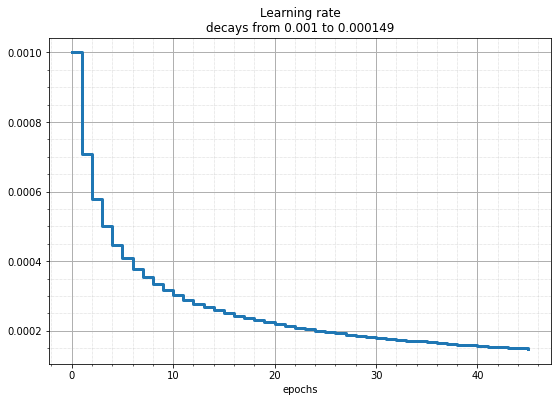

In [ ]:
# Learning rate decay function.
def lr_decay(epoch):
  return LR_RATE / math.sqrt(1+epoch)

# Utility callback that reflects the learning rate decay.
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0], y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')

# Display the learning rate decay.
plot_learning_rate(lr_decay, EPOCHS)

### Visualisation functions

In [ ]:
def accuracy_result(model):
  # Result for accuracy.
  plt.plot(model.history['accuracy'])
  plt.plot(model.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [ ]:
def loss_result(model):
  # Result for loss.
  plt.plot(model.history['loss'])
  plt.plot(model.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

### Network Architecture

In [ ]:
class LogitNetwork(tf.keras.Model):

  def __init__(self):
    super(LogitNetwork, self).__init__()

    # Initialising the network layer.
    self.initialiser = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)

  def initialise(self):
    # Network design.
    model = tf.keras.Sequential() # Initial network.
    model.add(RegularisedLayer())
    model.add(tf.keras.layers.Dense(10, 
                                activation='softmax', 
                                kernel_initializer=self.initialiser,
                                #kernel_regularizer=tf.keras.regularizers.L2(0.01)
                                )) # Output layer.
    return model
    

  def __call__(self, optimiser):
    model = self.initialise()
    model.compile(optimizer=optimiser, 
                  loss=CrossEntropy(),
                  metrics=["accuracy"]
                  )
    
    return model

## Network initialisation

In [ ]:
model = LogitNetwork()

## Testing different optimisers

In [ ]:
# Dictionary of 4 different optimisers.
optimiser_list = {
    "SGD": tf.optimizers.SGD(learning_rate=LR_RATE, momentum=MOMENTUM, name="SGD"),
    "Nesterov": tf.keras.optimizers.SGD(learning_rate=LR_RATE, momentum=MOMENTUM, nesterov=True, name='Nesterov'),
    "AdaGrad": tf.keras.optimizers.Adagrad(learning_rate=LR_RATE, name='AdaGrad'),
    "ADAM": tf.keras.optimizers.Adam(learning_rate=LR_RATE, name='ADAM')
}
model_output = dict()

In [ ]:
# Looping through 4 different optimisers.
def loop_model(optimiser_list, x_train, y_train, BATCH_SIZE, EPOCHS):

  # Initialise output dictionary.
  model_config = {}
  model_history = {}

  # Implement optimiser and fitting the network.
  for key, item in optimiser_list.items():
    print("\n")
    print(f"#### {key} Training ####")
    model_config[key] = model(item)
    model_history[key] = model_config[key].fit(x_train,
                                               y_train,
                                               batch_size=BATCH_SIZE,
                                               epochs=EPOCHS,
                                               validation_data=(x_test, y_test),
                                               verbose=False,
                                               callbacks=[lr_decay_callback])
  return model_config, model_history

model_config, model_history = loop_model(optimiser_list, x_train, y_train, BATCH_SIZE, EPOCHS)



#### SGD Training ####

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0007071067811865475.

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0005773502691896258.

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0005.

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0004472135954999579.

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0004082482904638631.

Epoch 00007: LearningRateScheduler reducing learning rate to 0.0003779644730092272.

Epoch 00008: LearningRateScheduler reducing learning rate to 0.00035355339059327376.

Epoch 00009: LearningRateScheduler reducing learning rate to 0.0003333333333333333.

Epoch 00010: LearningRateScheduler reducing learning rate to 0.00031622776601683794.

Epoch 00011: LearningRateScheduler reducing learning rate to 0.00030151134457776364.

Epoch 00012: LearningRateScheduler reducing learning rate to 0.0002

### SGD

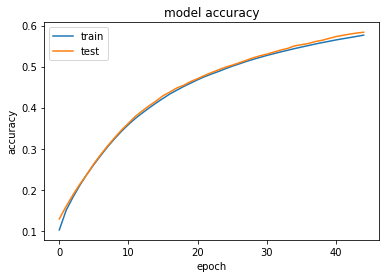

In [ ]:
accuracy_result(model_history["SGD"])

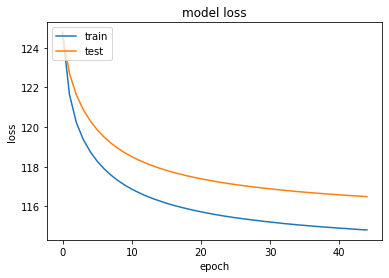

In [ ]:
loss_result(model_history["SGD"])

In [ ]:
# Model evaluation.
print("Evaluate on test data")
results = model_config["SGD"].evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)

Evaluate on test data
79/79 [==============================] - 0s 2ms/step - loss: 116.4924 - accuracy: 0.5836
test loss, test acc: [116.49236297607422, 0.5835999846458435]


#### Comment:

SGD optimiser shows the accuracy of 52.9%. This model performance cannot be considered to have a fair discrimination power and this could be due to the architecture structure or a structural limitation of sequential dense nerual network. Or even, this could be due to the optimisation issue. Hence, CNN network architecture or introduction of other optimisation algorithms could resolve the potential issue.

The model accuracy tends to increase as the number of epochs increases. This indicates that a larger number of tranining iterations could improve the model performance further. In addition, given the drop-out is not set, the higher test accuracy indicates that the model does not suffer an overfitting problem. 

### Nesterov Momentum SGD

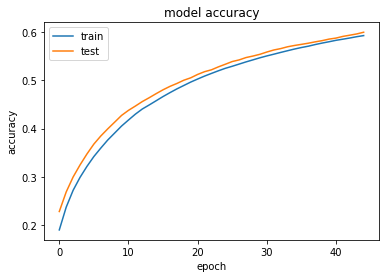

In [ ]:
accuracy_result(model_history["Nesterov"])

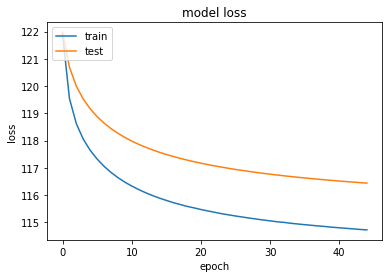

In [ ]:
loss_result(model_history["Nesterov"])

In [ ]:
# Model evaluation.
print("Evaluate on test data")
results = model_config["Nesterov"].evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)

Evaluate on test data
79/79 [==============================] - 0s 2ms/step - loss: 116.4408 - accuracy: 0.5996
test loss, test acc: [116.44084930419922, 0.5996000170707703]


#### Comment:

Similar to vanilla SGD, Nesterov Momentum SGD optimiser shows the accuracy of 55.2%. This model performance shows a slightly better result that vanilla SGD. However, this cannot be considered to have a fair discrimination power as well and this could be due to the architecture structure or a structural limitation of sequential dense nerual network. Or even, this could be due to the optimisation issue. Hence, CNN network architecture or introduction of other optimisation algorithms could resolve the potential issue.

The model accuracy tends to increase as the number of epochs increases. This indicates that a larger number of tranining iterations could improve the model performance further. In addition, given the drop-out is not set, the higher test accuracy indicates that the model does not suffer an overfitting problem. 

### AdaGrad

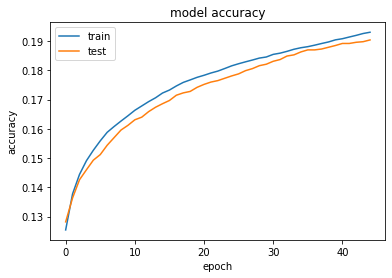

In [ ]:
accuracy_result(model_history["AdaGrad"])

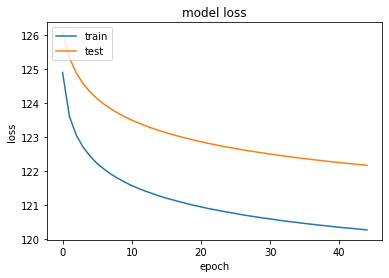

In [ ]:
loss_result(model_history["AdaGrad"])

In [ ]:
# Model evaluation.
print("Evaluate on test data")
results = model_config["AdaGrad"].evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)

Evaluate on test data
79/79 [==============================] - 0s 2ms/step - loss: 122.1703 - accuracy: 0.1904
test loss, test acc: [122.17027282714844, 0.19040000438690186]


#### Comment:

Surprisingly, AdaGrad optimiser shows the accuracy of 19.2%. This model performance shows a significantly lower performance compared to the earlier two optimsers. Hence, this model is considered to have very poor discrimination power which could be due to the architecture structure or a structural limitation of sequential dense nerual network. Considering the earlier results of other optimisers, AdaGrad optimiser needs a better hyperparameter tunning in this case (Calibration on learning rate, and other parameters).

The model accuracy tends to increase as the number of epochs increases. This indicates that a larger number of tranining iterations could improve the model performance further. In addition, given the drop-out is not set, the higher test accuracy indicates that the model does not suffer an overfitting problem. 

### Adam

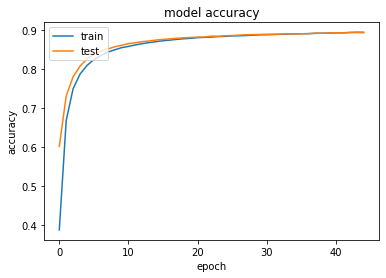

In [ ]:
accuracy_result(model_history["ADAM"])

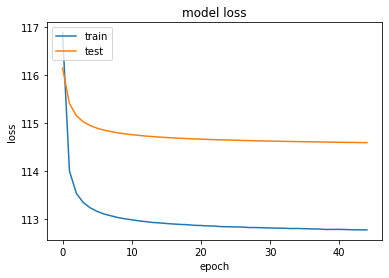

In [ ]:
loss_result(model_history["ADAM"])

In [ ]:
# Model evaluation.
print("Evaluate on test data")
results = model_config["ADAM"].evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)

Evaluate on test data
79/79 [==============================] - 0s 2ms/step - loss: 114.5949 - accuracy: 0.8925
test loss, test acc: [114.5949478149414, 0.8924999833106995]


#### Comment:

As expected, Adam optimiser shows the best performance with accuracy of 89.2%. This model performance shows a significantly better performance compared to the earlier optimsers. Hence, this model is considered to have a decent discrimination power. 

### Final conclusion:

In [ ]:
import matplotlib._color_data as mcd

In [ ]:
css4 = list(mcd.CSS4_COLORS.values())
xkcd = list(mcd.XKCD_COLORS.values())
def accuracy_result(model_dict):
  # Result for accuracy.
  labels = []
  for i, (key, model) in enumerate(model_dict.items()):
    plt.plot(model.history['accuracy'], css4[i*5+7], linewidth=2)
    plt.plot(model.history['val_accuracy'], css4[i*5+7], linestyle=":")
    labels.append(f"TRAIN: {key}")
    labels.append(f"TEST: {key}")
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(labels, loc='upper left', bbox_to_anchor=(1., 1.1))
  plt.show()

In [ ]:
def loss_result(model_dict):
  # Result for loss.
  labels = []
  for i, (key, model) in enumerate(model_dict.items()):
    plt.plot(model.history['loss'], css4[i*5+7], linewidth=2)
    plt.plot(model.history['val_loss'], css4[i*5+7], linestyle=":")
    labels.append(f"TRAIN: {key}")
    labels.append(f"TEST: {key}")
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(labels, loc='upper left', bbox_to_anchor=(1., 1.1))
  plt.show()

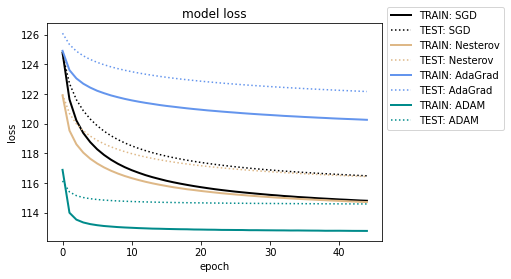

In [ ]:
loss_result(model_history)

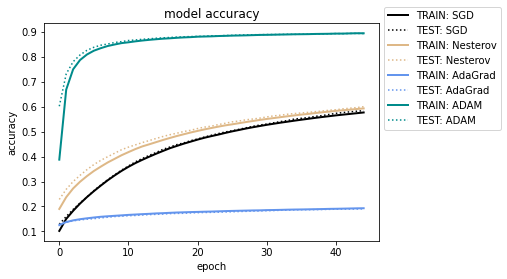

In [ ]:
accuracy_result(model_history)

As explained earlier, ADAM performs the first best, Nesterov SGD follows next and then the vanilla SGD with the momentum. Hence, ADAM is the most optimal choice for our model optimiser.

# P2

## P2. CIFAR10 CNN: convergence of minibatch gradient descent

Implement a CNN architecture that consists of 3 convolutional layers followed by a hidden fully connected layer of 1000 units. 

Each convolutional layer consists of a sublayer of 5x5 convolutional filters with stride 1 followed by a sublayer of 2x2 max-pool units with stride 2. Each neuron applies ReLU activation function.

**Task:** Evaluate **both the training and test loss function values** versus the number of epochs. In addition, show the results by adding dropout. Comment the results. 

**Hints:**

- Load CIFAR10 data by the following code:
```
from keras.datasets import cifar10
(data_train, label_train), (data_test, label_test) = cifar10.load_data()
```
- In order to reduce the training time, use only the first 50 mini-batches for each epoch. 
- More specifically, at the beginning of each epoch, randomly shuffle the whole dataset training dataset. Then, only iterate through the first 50 mini-batches for one epoch training.  
- Training on Google Colab GPU is highly recommended. The training time on 1 GPU is roughly 1 minute per epoch.  

The hyper-parameter settings:
- minibatch size = 128 
- learning rate = 0.001
- total number of epoches = 100

## Network Construction

### Hyperparameter

In [ ]:
EPOCHS = 100
BATCH_SIZE = 128
LR_RATE = 0.001
STEPS_PER_EPOCH = 50
NUM_CLASS = 10

### Data

In [ ]:
from keras.datasets import cifar10
(x_train,y_train), (x_test,y_test) = cifar10.load_data()

In [ ]:
# Convert from integers to floats + Normalisation to range 0 to 1.
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, NUM_CLASS)
y_test = keras.utils.to_categorical(y_test, NUM_CLASS)

# Checking data size.
print("Train: ", x_train.shape, y_train.shape)
print("Test: ", x_test.shape, y_test.shape)

Train:  (50000, 32, 32, 3) (50000, 10)
Test:  (10000, 32, 32, 3) (10000, 10)


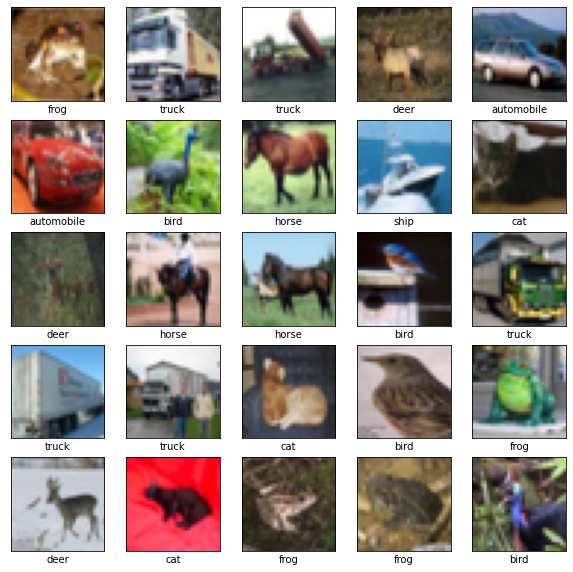

In [ ]:
# setting class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[np.where(y_train[i] == 1)[0][0]])
plt.show()

## Network Architecture

### Without drop-out

In [ ]:
class SimpleCnnNetwork(tf.keras.Model):
  """
  Doc string skipped, please refer to comment on each line of codes.
  """

  def __init__(self, drop_out):
    super(SimpleCnnNetwork, self).__init__()
    self.drop_out = drop_out

  def conv_layer(self, model, filters):
    """
    A boilerplate of convolution layer.
    """
    # Convolution layer contains 5x5 Kernel, striding by 1.
    model.add(layers.Conv2D(filters, (5,5), padding='same', strides=1, kernel_initializer='he_uniform', use_bias=True))
    # Relu activation function.
    model.add(tf.keras.layers.Activation('relu'))
    # Maxpooling layer, striding by 2, padding applied.
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    # Drop-out by 20% (Preventing overfitting).
    model.add(layers.Dropout(self.drop_out))
    return model

  def initialise(self):
    # Network design.
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(32, 32, 3), dtype=tf.float32))

    # Convolution 1 (64 filters).
    model = self.conv_layer(model, 64)
    
    # Convolution 2 (128 filters).
    model = self.conv_layer(model, 128)

    # Convolution 3 (256 filters).
    model = self.conv_layer(model, 256)

    # Full Connected Layer.
    model.add(layers.Flatten())
    model.add(layers.Dense(1000, activation='relu', kernel_initializer='he_uniform'))
    model.add(layers.Dropout(self.drop_out))
    model.add(layers.Dense(10, activation='softmax'))
  
    return model
    

  def __call__(self, optimiser):
    model = self.initialise()
    model.compile(optimizer=optimiser, 
                  loss="categorical_crossentropy",
                  metrics=["accuracy"]
                  )
    
    return model

In [ ]:
# Model initialisation.
cnn_classifer = SimpleCnnNetwork(0)

# Stochastic Gradient Descent Algorithm.
sgd = tf.keras.optimizers.SGD(learning_rate=LR_RATE, momentum=MOMENTUM, name="SGD")
cnn_classifer = cnn_classifer(sgd)

In [ ]:
cnn_classifer.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        4864      
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)        

In [ ]:
# Model fitting, verbose=True.
cnn_history = cnn_classifer.fit(x_train, 
                                y_train, 
                                epochs=EPOCHS,
                                shuffle=True,
                                batch_size=BATCH_SIZE,
                                steps_per_epoch=STEPS_PER_EPOCH,
                                validation_data=(x_test, y_test),
                                verbose=False)

In [ ]:
_, acc = cnn_classifer.evaluate(x_test, y_test, verbose=0)
print("Model Evaluation result: > %.3f" % (acc * 100.0))

Model Evaluation result: > 60.250


### Drop out (20%)

In [ ]:
# Model initialisation.
cnn_classifer_dropout = SimpleCnnNetwork(0.2)

# Stochastic Gradient Descent Algorithm.
sgd = tf.keras.optimizers.SGD(learning_rate=LR_RATE, momentum=MOMENTUM, name="SGD")
cnn_classifer_dropout = cnn_classifer_dropout(sgd)

In [ ]:
cnn_classifer_dropout.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
activation_3 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
activation_4 (Activation)    (None, 16, 16, 128)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 128)        

In [ ]:
# Model fitting, verbose=True.
cnn_dropout_history = cnn_classifer_dropout.fit(x_train, 
                                y_train, 
                                epochs=EPOCHS,
                                shuffle=True,
                                batch_size=BATCH_SIZE,
                                steps_per_epoch=STEPS_PER_EPOCH,
                                validation_data=(x_test, y_test),
                                verbose=False)

In [ ]:
_, acc = cnn_classifer_dropout.evaluate(x_test, y_test, verbose=0)
print("Model Evaluation result: > %.3f" % (acc * 100.0))

Model Evaluation result: > 50.880


### Result

In [ ]:
cnn_dict = {
    "Without Drop-out": cnn_history, 
    "With Drop-out": cnn_dropout_history
}

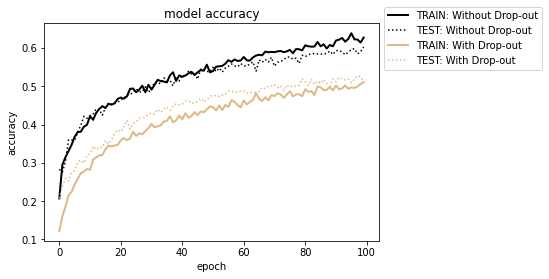

In [ ]:
accuracy_result(cnn_dict)

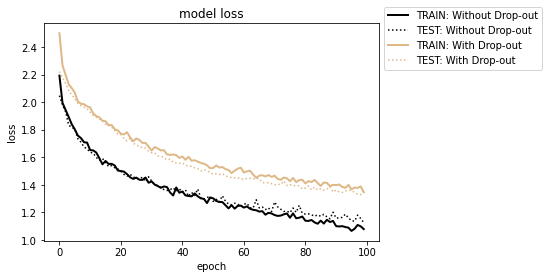

In [ ]:
loss_result(cnn_dict)

## Comment:

Compared to the simple sequential dense layer network that I represented in P1, the model accuracy of simple CNN network does not show a better performance. This could be due to the compromise that I made, introducing the smaller number of batches per epoch (50) setting to train the model faster. In addition, the chosen optimiser, the vanilla SGD with momentum could be falling into the local minima before reaching to the global minima (or possibly the number of trainings is not enough to reach the global minima). Hence, removal of number of batch size per epoch and introduction of different optimiser (e.g. Adam) could improve the model accuracy significantly. This will be revisited in the next section.

The model without drop-out tends to perform better than the model with drop-out. In addition, surprisingly, the model without drop-out does not indicate a significant deviation (64% & 60%) between training & testing performance. However, still the model with drop-out indicates a much closer metric between training & testing dataset. (49% & 52%)

 # P3

## P3. CIFAR10 image classification

Design and implement a convolutional neural network for the CIFAR10 image classification task aiming to achieve a high test accuracy. Evaluate the classification accuracy by reporting top-1 and top-5 test error rates. 

**Task:** Plot the loss function, top-1 error rate and top-5 error rate per epoch versus the number of epochs for the training and the test dataset. 
Make sure to well describe and justify your network architecture design choices. 

### Description on the modelling steps

Leveraging the previous result that I retrieved from P2, using the simple CNN model with SGD optimiser, I will try different model layout (inspired by the literature) and hyperparameter values to test if the model accuracy enhancement can be achieved.

## Network Architecture

### Hyperparameter

In [ ]:
EPOCHS = 100
BATCH_SIZE = 128
LR_RATE = 0.001
STEPS_PER_EPOCH = 50
NUM_CLASS = 10

### VGG model

Inspired by VGG.
paper: [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)

In [ ]:
class VggCnnNetwork(tf.keras.Model):
  """
  Doc string skipped, please refer to comment on each line of codes.
  """

  def __init__(self):
    super(VggCnnNetwork, self).__init__()

  def vgg_conv_layer(self, model, filters):
    # Doubled convolution layers.
    for i in range(0,2):
      model.add(layers.Conv2D(filters, 3, padding='same', strides=1, kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.001)))
      model.add(layers.BatchNormalization(center=True, scale=False))
      model.add(tf.keras.layers.Activation('relu'))

    # Maxpooling layer, striding by 2, padding applied.
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
    model.add(layers.Dropout(0.2))
    return model

  def initialise(self):
    # Network design.
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(32, 32, 3), dtype=tf.float32))

    # Convolution 1.
    model = self.vgg_conv_layer(model, 32)

    # Convolution 2.
    model = self.vgg_conv_layer(model, 64)

    # Convolution 3.
    model = self.vgg_conv_layer(model, 128)

    # Full Connected Layer.
    model.add(layers.Flatten())
    model.add(layers.Dense(1000, activation='relu', kernel_initializer='he_uniform'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(10, activation='softmax'))
    return model
    

  def __call__(self, optimiser):
    model = self.initialise()
    model.compile(optimizer=optimiser, 
                  loss="categorical_crossentropy",
                  metrics=["accuracy",
                           tf.keras.metrics.TopKCategoricalAccuracy(k=1, name="Top_1_Accuracy"),
                           tf.keras.metrics.TopKCategoricalAccuracy(k=5, name="Top_5_Accuracy")]
                  )
    return model

## Running Model

In [ ]:
vgg_classifer = VggCnnNetwork()

### Optimiser: ADAM

Considering the superior performance of ADAM optimiser that I presented on P1, it is decided to use ADAM as our primary optimiser.

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=LR_RATE, name='ADAM')

### Model summary

In [ ]:
vgg_baseline = vgg_classifer(opt)

In [ ]:
# VGG inspired CNN network.
vgg_baseline.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        96        
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        96        
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)       

VGG inspired network has a lot less parameters compared to the simple CNN network. On the later section, I will compare the model performance and see if the larger number of parameters improves the performance.

#### Baseline

In [ ]:
vgg_base_hist = vgg_baseline.fit(x_train,
                                y_train,
                                epochs=EPOCHS,
                                shuffle=True,
                                batch_size=BATCH_SIZE,
                                steps_per_epoch=STEPS_PER_EPOCH,
                                validation_data=(x_test, y_test),
                                verbose=False)

In [ ]:
_, acc, top1, top5 = vgg_baseline.evaluate(x_test, y_test, verbose=0)
print("Model Training Accuracy: %.2f%%" % (vgg_base_hist.history['accuracy'][-1]*100))
print("Model Evaluation result: > %.3f" % (acc * 100.0))
print("Top 5 Error rate: %.2f%%" % ((1-top5) * 100.0))
print("Top 1 Error rate: %.2f%%" % ((1-top1) * 100.0))

Model Training Accuracy: 82.48%
Model Evaluation result: > 74.180
Top 5 Error rate: 1.58%
Top 1 Error rate: 25.82%


#### Candidate 1

As explainde earlier, the cnadidate 1 model will un-limit the steps-per-epoch parameter. This will inevitably increase the required computation per epoch due to the sheer amount of data to process, however this will increase the model accuracy as more records of data are sourced into network training.

In [ ]:
vgg_classifer = VggCnnNetwork()
vgg_mod1 = vgg_classifer(opt)

In [ ]:
vgg_mod1_hist = vgg_mod1.fit(x_train,
                                y_train,
                                epochs=EPOCHS,
                                shuffle=True,
                                batch_size=BATCH_SIZE,
                                validation_data=(x_test, y_test),
                                verbose=False)

In [ ]:
_, acc, top1, top5 = vgg_mod1.evaluate(x_test, y_test, verbose=0)
print("Model Training Accuracy: %.2f%%" % (vgg_mod1_hist.history['accuracy'][-1]*100))
print("Model Evaluation result: > %.3f" % (acc * 100.0))
print("Top 5 Error rate: %.2f%%" % ((1-top5) * 100.0))
print("Top 1 Error rate: %.2f%%" % ((1-top1) * 100.0))

Model Training Accuracy: 93.29%
Model Evaluation result: > 82.180
Top 5 Error rate: 0.81%
Top 1 Error rate: 17.82%


#### Comment

Based on the result of candidate 1, as expected, the training time increased significantly. In addition, in line with the expectation, both training & testing accuracy increased compared to the baseline model. Again, this result is not a surprise as the larger amount of number crunching associated by larger batch per epoch resulted more precise model parameter tuning in the end. However, as mentioned earlier, this is not a free-lunch result given the significantly larger amount of training time compared to the baseline.

#### Candidate 2

The next model specification will also un-limit the steps-per-epoch. In addition, the optimiser setting is re-adjusted. Following the ADAM optimiser setting in ImageNet Inception network, the next model will use the ADAM optimiser with epsilon equal to 0.1.

In [ ]:
opt2 = tf.keras.optimizers.Adam(learning_rate=LR_RATE, epsilon=0.1, name='ADAM')

In [ ]:
vgg_classifer = VggCnnNetwork()
vgg_mod2 = vgg_classifer(opt2)

In [ ]:
vgg_mod2_hist = vgg_mod2.fit(x_train,
                                y_train,
                                epochs=EPOCHS,
                                shuffle=True,
                                batch_size=BATCH_SIZE,
                                validation_data=(x_test, y_test),
                                verbose=False)

In [ ]:
_, acc, top1, top5 = vgg_mod2.evaluate(x_test, y_test, verbose=0)
print("Model Training Accuracy: %.2f%%" % (vgg_mod2_hist.history['accuracy'][-1]*100))
print("Model Evaluation result: > %.3f" % (acc * 100.0))
print("Top 5 Error rate: %.2f%%" % ((1-top5) * 100.0))
print("Top 1 Error rate: %.2f%%" % ((1-top1) * 100.0))

Model Training Accuracy: 88.39%
Model Evaluation result: > 82.840
Top 5 Error rate: 0.87%
Top 1 Error rate: 17.16%


#### Comment

Based on the result of candidate 2, due to the larger size of batch per epoch, the training time increased significantly compared to the baseline. However, introduction of new epsilon parameter value did not improve the training & testing accuracy. Hence, the new hyperparemeter tuning in candidate 2 model is not deemed to be necessary.

## Conclusion:

In [ ]:
def top_k_error(model_dict, k):
  # Result for top k error rate.
  labels = []
  for i, (key, model) in enumerate(model_dict.items()):
    plt.plot([1 - i for i in model.history[f'Top_{k}_Accuracy']], css4[i*5+7], linewidth=2)
    plt.plot([1 - i for i in model.history[f'val_Top_{k}_Accuracy']], css4[i*5+7], linestyle=":")
    labels.append(f"TRAIN: {key}")
    labels.append(f"TEST: {key}")
  plt.title(f'Top {k} error rate')
  plt.ylabel('Error rate')
  plt.xlabel('epoch')
  plt.legend(labels, loc='upper left', bbox_to_anchor=(1., 1.1))
  plt.show()

In [ ]:
model_result_hist = {"Baseline": vgg_base_hist,
                     "Candidate 1": vgg_mod1_hist,
                     "Candidate 2": vgg_mod2_hist}

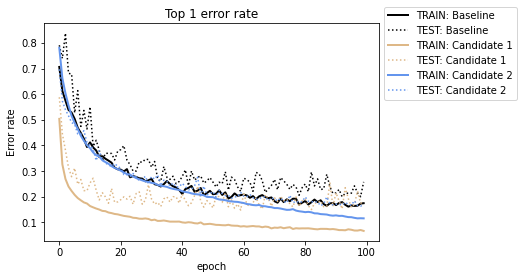

In [ ]:
top_k_error(model_result_hist, k=1)

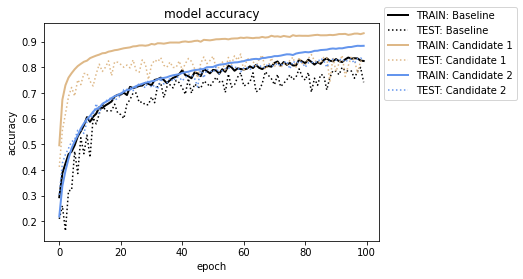

In [ ]:
accuracy_result(model_result_hist)

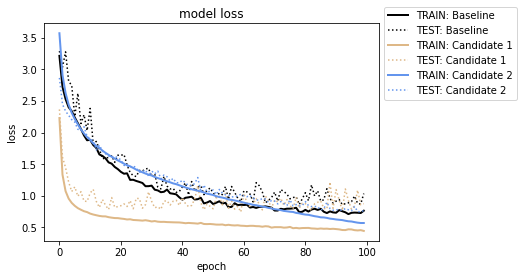

In [ ]:
loss_result(model_result_hist)

Based on the model results above, 3 different VGG model inspired network specifications were examined, and the candidate 1 model showed the best performance. This candidate 1 model has less number of parameters to train compared to the simple CNN model in P2 (P2 CNN: 5M vs VGG candidate 1: 2.3M). Furthermore, the model accuracy has increased significantaly. Hence, VGG inspired candidate 1 model is considered to be the best model among the others. This could be due to the following reasons:
- ADAM optimiser, known to perform better than SGD
- Network structure (VGG has 3 doubled convolution layers whereas CNN in P2 has 3 single convolution layers.)
- Size of batch per epch

Based on review of various metrics including top-k error rate, model accuracy and loss results, all the test results are shown to be lower than the train results. Considering the fact that the drop-out option is incorporated within all 3 models, it is surprising to see the result that there is still a deviation between training and testing results. Perhaps, this could be further improved by hyperparameter tuning of drop-out rate and re-construction of CNN network.

-----------------------   


## Marking scheme

| **Problem breakdown** | **Max marks** | 
|-------------------|---------------|
| P1 correctness of implementation	|	15 |	
| P1 discussion of results	|	15 |
| P2 correctness of implementation    |	15  |
| P2 discussion of results	|	15 |
| P3 network architecture design    |	10 |
| P3 use of different methods   | 10 |
| P3 achieved test error rates    |   10 |
| P3 discussion and presentation of results | 10 |
| | Total 100 |
